In [78]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
resp = requests.get('https://data.ct.gov/resource/rf3k-f8fg.json')
txt = resp.json()

In [23]:
dat_orig = pd.DataFrame(txt)


In [60]:
dat = dat_orig[dat_orig['state']=='CONNECTICUT']

dat = dat[['date', 'cases', 'deaths', 'cases_age0_9']]

cols = dat.columns.drop('date')

dat[cols] = dat[cols].apply(pd.to_numeric, errors='coerce')

dat['date'] = dat['date'].apply(pd.to_datetime)

In [63]:
sort_dat = dat.sort_values(by=['date'], inplace=False, ascending=True)

In [68]:
sort_dat['daily_new_cases'] = sort_dat['cases'].diff()
sort_dat['daily_new_deaths'] = sort_dat['deaths'].diff()
sort_dat['daily_new_child_cases'] = sort_dat['cases_age0_9'].diff()

In [76]:
sort_dat['new_cases_roll3'] = sort_dat['daily_new_cases'].rolling(3).mean().round()
sort_dat['new_cases_roll7'] = sort_dat['daily_new_cases'].rolling(7).mean().round()
sort_dat['new__child_cases_roll3'] = sort_dat['daily_new_child_cases'].rolling(3).mean().round()
sort_dat['new__child_cases_roll7'] = sort_dat['daily_new_child_cases'].rolling(7).mean().round()
sort_dat['new_deaths_roll3'] = sort_dat['daily_new_deaths'].rolling(3).mean().round()
sort_dat['new_deaths_roll7'] = sort_dat['daily_new_deaths'].rolling(7).mean().round()

In [86]:
# sort_dat

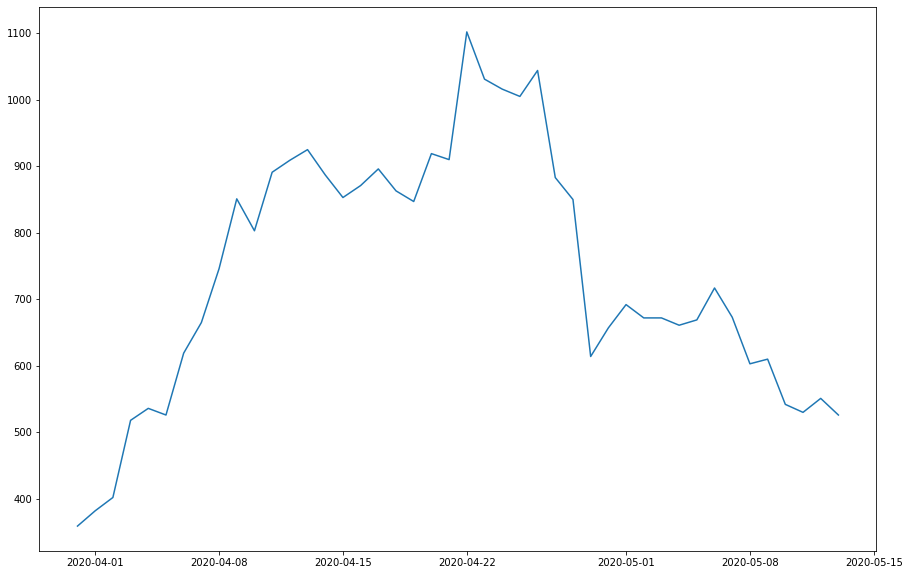

In [85]:
plt.figure(num = 20, figsize=(15, 10))
plt.plot(sort_dat['date'], sort_dat['new_cases_roll7'])
# plt.plot(sort_dat['date'], sort_dat['new_cases_roll3'])
# plt.plot(sort_dat['date'], sort_dat['daily_new_cases'])
# plt.plot(sort_dat['date'], sort_dat['new__child_cases_roll7'])
# plt.plot(sort_dat['date'], sort_dat['new_deaths_roll7'])

plt.show()